### References:
http://ruder.io/deep-learning-nlp-best-practices/index.html
Stanford course http://web.stanford.edu/class/cs224n/
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/47581
https://github.com/phatpiglet/autocorrect/
http://pythonhosted.org/pyenchant/tutorial.html
https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/
TextBlob: http://textblob.readthedocs.io/en/dev/quickstart.html#spelling-correction

In [1]:
import autocorrect
from autocorrect import spell
spell('Aaaand')
import enchant
d = enchant.Dict("en_US")
d.check("mother")
d.suggest("f@got")
from textblob import TextBlob
test = TextBlob('Annnd')
test.correct()

TextBlob("Annnd")

In [2]:
from collections import Counter
import random
import re
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns
import nltk
import numpy as np
import pandas as pd
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import random
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
from IPython.core.display import display, HTML
import IPython.display
%matplotlib inline
#to disable warnings
import warnings
warnings.filterwarnings('ignore')
import calendar

Using TensorFlow backend.


# Load the data

In [3]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")
#train_data.head()
print("Shape of the data: {}".format(train_data.shape))
train_size=train_data.shape[0]
print("Number of samples: {}".format(train_size))
# There are 6 types: 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate'.
types = train_data.columns[2:]
train_text = train_data['comment_text']
train_targets=train_data[types]

Shape of the data: (159571, 8)
Number of samples: 159571


In [75]:
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [74]:
train_data.comment_text[train_data.toxic==1].iloc[0]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

# Text statistics

In [4]:
train_length = train_text.str.len()
average_length_comment = train_length.mean()
print("Average legth of a comment: {}".format(average_length_comment))
total_length_comments = train_length.sum()
print("Total number of characters: {} (= 62 millions)".format(total_length_comments))

Average legth of a comment: 394.0732213246768
Total number of characters: 62882658 (= 62 millions)


In [5]:
def sent_tok(text):
    """Takes a text and returns a list of sentences."""
    return nltk.sent_tokenize(text)
def tokenize(sentence):
    """Takes a sentence and returns a tokenized one."""
    return nltk.word_tokenize(sentence)
stopwords = nltk.corpus.stopwords.words("english")
def lower_tokenized(tokenized):
    """Put a list of tokens in lower case."""
    return [token.lower() for token in tokenized]
def remove_stopwords(a):
    """Takes an array of words and returns the same array with stopwords removed."""
    return [w for w in a if w.lower() not in stopwords]
def pos_tag(tokenized_sentence):
    return nltk.pos_tag(tokenized_sentence)
wordnet_lemmatizer = WordNetLemmatizer()
# wordnet_lemmatizer.lemmatize('leaves')
# wordnet_lemmatizer.lemmatize('leaves','n')
# wordnet_lemmatizer.lemmatize('leaves','v')
def convert_tag(tag):
    """Convert the tag given by nltk.pos_tag to the tag used by wordnet.synsets"""
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try: return tag_dict[tag[0]]
    except KeyError: return 'n'
def convert_tagged(tagged):
    """convert a pos tagged with nltk to a tagged word in wordnet"""
    word = tagged[0]
    tag = tagged[1]
    return word, convert_tag(tag)
def lemmatize_sentence(sentence):
    """Take a sentence and returns the sequence of lemmas."""
    tokenized = tokenize(sentence)
    pos_tagged = pos_tag(tokenized)
    pos_tagged_wn = (convert_tagged(w) for w in pos_tagged)
    return [wordnet_lemmatizer.lemmatize(*w) for w in pos_tagged_wn]
def is_word(w):
    """Check if there is a letter in w."""
    return bool(re.match(r'\w',w))
def remove_punctuation(sentence):
    """Takes a set of words and removes the non words."""
    return [w for w in sentence if is_word(w)]

In [6]:
# train_tokens = train_text.apply(lambda sent: lemmatize_sentence(sent))
# pickle.dump(train_tokens,open("train_tokens","wb"))
train_tokens = pickle.load(open("train_tokens","rb"))
chain = itertools.chain(*train_tokens)
list_of_tokens = list(chain)
print("Total number of tokens: {}".format(len(list_of_tokens)))
# TURN IN LOWER CASE
chain = itertools.chain(*train_tokens)
set_of_tokens = set(chain)
list_of_set_of_tokens = list(set_of_tokens)
print("Total number of distinct tokens: {}".format(len(set_of_tokens)))
#random.choice(list_of_set_of_tokens)

Total number of tokens: 12817094
Total number of distinct tokens: 293497


## Utilities to extract information

In [7]:
def statistics(mask,data=train_data,prop ='property',types=types):
    """Takes a boolean array of indices in data, and plot barplots relative to that property."""
    with_prop=np.where(mask,'with '+prop,'without '+prop)
    data['prop']=with_prop
    plt.figure(figsize=(12,8))
    for i,t in enumerate(types):
        plt.subplot(2,3,i+1)
        sns.barplot(x='prop',y=t,data=data)
        plt.title(t)
    plt.tight_layout()

# Preprocess  comments

In [8]:
set_tags= set()

In [9]:
def before_after(tag,data=train_text):
    """Takes a tagger for a series of comments, prints % of tagged comments."""
    data_before=data
    data_after = tag(data_before)
    diff = data_before != data_after
    avg = diff.mean()
    print("{}% of the comments have been tagged.".format(avg*100))

## Remove IP Adress

In [10]:
raw_regex_IP = r'(\d{1,3})\.(\d{1,3})\.(\d{1,3})\.(\d{1,3})'
IP_regex = re.compile(raw_regex_IP)
TAG_IP_ADDRESS = 'TAG_IP_ADDRESS'
set_tags.add(TAG_IP_ADDRESS)
# regex_train_check = train_text.str.contains(regex_IP)
# regex_train_text = train_text[regex_train_check]
# ips_train_text = train_text.str.extract(regex_IP)
# b = train_text.str.replace(regex_IP,TAG_IP_ADDRESS)
# print(train_text[50483])
# print(b[50483])
# comment = regex_train_text.iloc[42]
# comment
# regex_IP.search(comment).group(0)
#print("{} % of the comments have an IP address.".format(regex_train_check.mean()*100))

def tagger_IPaddress(comment,TAG_IP_ADDRESS=TAG_IP_ADDRESS):
    """Takes a comment and replace an IP address (if any) by TAG_IP_ADDRESS"""
    return IP_regex.sub(" "+TAG_IP_ADDRESS+" ",comment)

def tag_IPaddress(data=train_text,TAG_IP_ADDRESS=TAG_IP_ADDRESS):
    """Take a series of text, and return a series with tags for the IP addresses."""
    data1 = data.str.replace(IP_regex," "+TAG_IP_ADDRESS+" ")
    return data1
#before_after(tag_IPaddress)

## Http and email adresses

In [11]:
TAG_HTTP = 'TAG_HTTP'
set_tags.add(TAG_HTTP)
regexs_http=[]
# http://....
raw_regex_http = r'(http|www)://\S*'
http_regex=re.compile(raw_regex_http,re.I)
regexs_http.append(http_regex)
# wwwfuiue.??
raw_regex_http = r'www\S*\.\w{2,3}'
http_regex=re.compile(raw_regex_http,re.I)
regexs_http.append(http_regex)
# ...@jfdkjf.fjk
raw_regex_email = r'\S*\w\@\w+\.\S+'
email_regex=re.compile(raw_regex_email,re.I)
regexs_http.append(email_regex)
def tagger_http(comment,TAG_HTTP = 'TAG_HTTP'):
    #regexs=[http_regex]
    return_comment = comment
    for regex in regexs_http:
        return_comment=regex.sub(" "+TAG_HTTP+" ",return_comment)
    return return_comment
def tag_http(data=train_text,TAG_HTTP =TAG_HTTP):
    for regex in regexs_http:
        data=data.str.replace(regex," "+TAG_HTTP+" ")
    return data
#tagged_train = tag_http(tagged_train)

## Images

In [12]:
TAG_IMAGE = 'TAG_IMAGE'
set_tags.add(TAG_IMAGE)

raw_regex_img1 = r'Image:(\s*\S*){1,9}?.(pdf|jpg|JPG|GIF|gif|jpeg|png|PNG|svg|m4a\?)[\w\|\=]*'
img_regex1 = re.compile(raw_regex_img1)
def tagger_img(comment,TAG_IMAGE = 'TAG_IMAGE'):
    regexs=[img_regex1]
    return_comment = comment
    for regex in regexs:
        return_comment=regex.sub(" "+TAG_IMAGE+" ",return_comment)
    return return_comment
def tag_img(data=train_text,TAG_IMAGE = TAG_IMAGE):
    data1 = data.str.replace(img_regex1, " "+TAG_IMAGE+" ")
    return data1
# takes one minute to run

## Dates and time
https://github.com/akoumjian/datefinder

In [13]:
TAG_DATE = 'TAG_DATE'
set_tags.add(TAG_DATE)

mon = [month[:3] for month in calendar.month_name[1:]]
mon_lower  = [month[:3].lower() for month in calendar.month_name[1:]]
months = calendar.month_name[1:]
months_lower = [month.lower() for month in months]
#months_regex = "|".join(months)
# months_rege_two = 'Jan|Feb|...|January...|December'
months_regex = "|".join(months+mon+months_lower+mon_lower)
months_regex_two = "|".join(months+mon+months_lower+mon_lower)
time_regex = []
#date in format 07:08, 29 2012  May 2012(UTC)
raw_regex_time = r'(\d\d:\d\d,)?\s*\d{1,2} \d\d\d\d\s*('+ months_regex_two + r')\s*((\d{4})?\(UTC\))?'
time_regex.append(re.compile(raw_regex_time))
#date in format 07:08, 2004 May 24 (UTC)
raw_regex_time = r'(\d\d:\d\d,)?\s*\d\d\d\d\s*('+ months_regex_two + r')\s*\d{1,2}\s*(\(UTC\))?'
time_regex.append(re.compile(raw_regex_time))
# date in format (17:01,) Nov(ember) 16, 2004 (UTC)
raw_regex_time = r'(\d\d:\d\d,)?\s*('+ months_regex_two + r')\s*\d{1,2}(,\s*\d\d\d\d)\s*(\(UTC\))?'
time_regex.append(re.compile(raw_regex_time))
# date in format 17:01, 16(th of.,) Nov(ember), 2004 (UTC)
raw_regex_time = r'(\d\d:\d\d,)?\s*\d{1,2}\s*(th|th\s*of|of|\.|\,)?\s*('+ months_regex_two + r')(,?\s*\d\d\d\d)?\s*(\(UTC\))?'
time_regex.append(re.compile(raw_regex_time))
# date in format 2008 (UTC)
raw_regex_time = r'\d{4}\s*\(UTC\)'
time_regex.append(re.compile(raw_regex_time))
#date in format 25/08/06
raw_regex_time = r'\d{1,2}/\d{2}/\d{2}(\d{2})?'
time_regex.append(re.compile(raw_regex_time))
#date in format January (7,) 2011 
raw_regex_time = r'('+months_regex_two+r')\s*(\d{1,2},?)?\s*\d{4}'
time_regex.append(re.compile(raw_regex_time))
# date as 03:28, 27 at the end of a comment
raw_regex_time = r'\d\d:\d\d,\s* \d{1,}\s*$'
time_regex.append(re.compile(raw_regex_time))
#date of the form 10:40, 27 S EOF
raw_regex_time = r'\d\d:\d\d,\s* \d{1,2}\s*\w{1,3}\s*$'
time_regex.append(re.compile(raw_regex_time))
#date of the form 10:40 
raw_regex_time = r'\d\d:\d\d'
time_regex.append(re.compile(raw_regex_time))
# a = train_text.str.replace(regex_date1,'TAG_DATE')
# a[144457]
# this replaces the dates of the form regex_date
# a1 = train_text.str.findall(time_regex1)
# (a1.apply(lambda l : bool(l))).mean()
# a2 = train_text.str.findall(time_regex2)
# (a2.apply(lambda l: bool(l))).mean()
# a3 = train_text.str.findall(time_regex3)
# (a3.apply(lambda l:  bool(l))).mean()
# a4 = train_text.str.findall(time_regex4)
# (a4.apply(lambda l:  bool(l))).mean()
# def study_regex(regex, text_series = train_text):
#     regex_matches = train_text.str.findall(regex)
#     matches_ratio = (regex_matches.apply(lambda l : bool(l))).mean()
#     return matches_ratio
# study_regex(time_regex5)
# text = train_text.iloc[142598]
# print(text)
# text=train_text[144457]
# print(text)

In [14]:
def tagger_time(comment,TAG_DATE = 'TAG_DATE'):
    return_comment = comment
    for regex in time_regex:
        return_comment=regex.sub(" "+TAG_DATE+" ",return_comment)
    return return_comment
#tagger_time(text)
def tag_time(data=train_text, TAG_DATE = TAG_DATE):
    for regex in time_regex:
        data = data.str.replace(regex, " "+TAG_DATE+" ")
    return data
#before_after(tag_time)

In [15]:
def tag_date_in_spacy_doc(doc):
    """Takes a spacy doc and returns a text with date tagged with TAG_DATE."""
    comment = str(doc)
    last_pos=0
    l = []
    for ent in doc.ents:
        if ent.label_==u'DATE':
            l.append(str(comment[last_pos:ent.start_char])+" "+TAG_DATE)
            last_pos=ent.end_char+1
    l.append(str(comment[last_pos:len(comment)]))
    new_comment = "".join(l)
    return new_comment 
# t = tag_date_in_spacy_doc(doc1)
# nlp(t).ents

## User names

In [16]:
TAG_USERNAME='TAG_USERNAME'
set_tags.add(TAG_USERNAME)
username_regex = re.compile(r'User:(\s*(\S+))?',re.I)
def tagger_username(comment):
    new_comment = re.sub(username_regex,' '+TAG_USERNAME + ' '+r'\1',comment)
def tag_username(data,TAG_USERNAME='TAG_USERNAME'):
    data1 = data.str.replace(username_regex,' '+TAG_USERNAME + ' '+r'\1')
    return data1
# re.sub(r'User:(\w+)',' '+TAG_USERNAME + ' '+r'\1', 'strin wi User:flotin ah ah!')

## TAB

In [17]:
TAG_TAB='TAG_TAB'
set_tags.add(TAG_TAB)

def tag_tab(data=train_text,TAG =TAG_TAB):
    data=data.str.replace(r'TAB'," "+TAG+" ")
    return data
#tagged_train = tag_tab(tagged_train)

## CSS tag

In [18]:
TAG_CSS = 'TAG_CSS'
set_tags.add(TAG_CSS)

regexs=[]
# {| ... \n
raw_regex = r'\{\|.*\n'
regex=re.compile(raw_regex,re.I)
regexs.append(regex)
#...style="...
raw_regex = r'\S*(class|style|align|width|rowspan|colspan|bgcolor)=\"\S*'
regex=re.compile(raw_regex,re.I)
regexs.append(regex)
# ..text-align:..
raw_regex = r'\S*(border|text-align|background-color|vertical-align|color|font-size):\S*'
regex=re.compile(raw_regex,re.I)
regexs.append(regex)
# | TAG_CSS . |
raw_regex = r'(\|[^\n]*)?'+TAG_CSS+r'[^\n]*\|'
regex=re.compile(raw_regex,re.I)
regexs.append(regex)
# colorhex
raw_regex = r'\S*\#[\dA-F]{6}\S*'
regex=re.compile(raw_regex,re.I)
regexs.append(regex)
# coup de grace: TAG_CSS ... TAG_CSS
raw_regex = TAG_CSS+r'[^\n]'+TAG_CSS
regex=re.compile(raw_regex,re.I)
regexs.append(regex)

def tagger_css(comment,TAG = 'TAG_CSS'):
    #regexs=[http_regex]
    return_comment = comment
    for regex in regexs:
        return_comment=regex.sub(" "+TAG+" ",return_comment)
    return return_comment
def tag_css(data=train_text,TAG =TAG_CSS):
    for regex in regexs:
        data=data.str.replace(regex," "+TAG+" ")
    return data
#tagged_train = tag_css(tagged_train)

## Smileys
I use a list taken from here: http://piology.org/smiley.txt

In [19]:
with open('smiley.txt','rb') as f:
    li = pickle.load(f)
lines = li.splitlines()
splitted_lines = [line.split() for line in lines]
smileys = [line[0] for line in splitted_lines[1:]]
set_smileys = set(smileys)

In [20]:
TAG_SMILEY = 'TAG_SMILEY'
set_tags.add(TAG_SMILEY)
def tagger_smiley(comment):
    tokenized = comment.split()
    for i,token in enumerate(tokenized):
        if token in set_smileys:
            tokenized[i]=TAG_SMILEY
    return " ".join(tokenized)

### Check spelling

In [21]:
# pyenchant (ex: t@lk)

## Talk

In [22]:
TAG_TALK = 'TAG_TALK'
set_tags.add(TAG_TALK)
regexs_talk = []
regexs_talk.append(r'Talk:')
regexs_talk.append(r'[uU]ser[\s_]talk:')
regexs_talk.append(r'[wW]ikipedia[\s_]talk:')
regexs_talk.append(r'\S*_talk:')
regexs_talk.append(r'talk:')

def tag_talk(data,TAG =TAG_TALK):
    for regex in regexs_talk:
        data=data.str.replace(regex," "+TAG+" ")
    return data

## Other tags

In [23]:
raw_regex_talk = r'\(talk\)'
talk_regex = re.compile(raw_regex_talk) #with pyenchant should work

def remove_quotes(comment):
    """Remove opening-closing quotes in a comment"""
    action = False
    if comment[0] in {'"','\n','#'}:
        del comment[0]
        action = True
    if comment[-1] in {'"','\n','#'}:
        del comment[-1]
        action = True
    if action:
        return remove_quotes(comment)
    return comment
def remove_trailing(data=train_text):
    """Remove quotes, \n, to train_text."""
    regex1=r"""^['"\n\s]*"""
    data1 = data.str.replace(regex1,"")
    regex2 = r'''['"\n\s]*$'''
    data2 = data1.str.replace(regex2,"")
    return data2
TAG_MISC = 'TAG_MISC'
set_tags.add(TAG_MISC)
regexs_misc=[]
regexs_misc.append(re.compile(r"REDIRECT (User )?talk:"))
regexs_misc.append(re.compile(r'Help:'))
regexs_misc.append(re.compile(r'Template:'))
regexs_misc.append(re.compile(r'Category:'))
def tag_misc(data=train_text,TAG =TAG_MISC):
    for regex in regexs_misc:
        data=data.str.replace(regex," "+TAG+" ")
    return data
TAG_TILDES='TAG_TIDLES'
set_tags.add(TAG_TILDES)
def tag_tildes(data):
    data = data.str.replace(r'\(~~~~\)',' '+TAG_TILDES+' ')
    data = data.str.replace(r'~~~~',' '+TAG_TILDES+' ')
    return data

# Wikipedia tag

In [24]:
TAG_WIKIPEDIA = 'TAG_WIKIPEDIA'
set_tags.add(TAG_WIKIPEDIA)
regexs_wiki=[]
regexs_wiki.append(r'WP:(?=\S)')
regexs_wiki.append(r'[wW]ikipedia:(?=\S)')
def tag_wiki(data=train_text,TAG =TAG_WIKIPEDIA):
    for regex in regexs_wiki:
        data=data.str.replace(regex," "+TAG+" ")
    return data

## Punctuation

In [25]:
def shorten_punctutation(data):
    data = data.str.replace(r"'{2,}",'"')
    data = data.str.replace(r'"{2,}','"')
    TAG_EQ = 'TAG_EQ'
    set_tags.add(TAG_EQ)
    data = data.str.replace(r'={2,}'," "+TAG_EQ+" ")
    TAG_PUNCT = 'TAG_PUNCT'
    set_tags.add(TAG_PUNCT)
    data = data.str.replace(r'([:!?])\1{1,}',' '+TAG_PUNCT+' ')
    return data

## Duplicates letters: aaaand

In [26]:
def shorten_duplicates(data):
    regex_duplicate = re.compile(r'([a-zA-Z])\1{2,}', re.I)
    data = data.str.replace(regex_duplicate, r'\1\1')
    return data

### Put all tagger together

In [27]:
def tagger(comment):
    return_comment = comment
    return_comment = tagger_IPaddress(comment)
    return_comment = tagger_time(return_comment)
    return return_comment
def tag_comments(data = train_text):
    data1 = remove_trailing(data)
    data2 = data1.apply(tagger)
    return data2

In [28]:
def tag(data=train_text):
    data0 = remove_trailing(data)
    data1 = tag_IPaddress(data0)
    data2 = tag_http(data1)
    data3 = tag_img(data2)
    data4 = tag_time(data3)
    data = tag_username(data4) 
    tag_list = [tag_css,tag_tab,tag_talk,tag_wiki,tag_misc]
    for tag in tag_list:
        data = tag(data)
    return data

In [29]:
# t = time.time()
# tagged_train = tag(train_text)
# time_exec = time.time()-t
# print("Time of execution: {} seconds.".format(time_exec))

In [30]:
# file = open("tagged_train","wb")
# pickle.dump(tagged_train,file)
# file.close()

In [41]:
file_reader = open("tagged_train","rb")
tagged_train= pickle.load(file_reader)
file_reader.close()

In [66]:
tagged_train.sample(1).iloc[0]

'Hi Abhishek, I started using the cite template in earnest ) I was a tad lazy to do it, but now I promise to do it with all my contributions henceforth, Thanks Randhir'

ADD TO THE VOCABULARY:

~~~~
ADD TO TAGS: 

\[ \[


# Patterns to tag

### Find some patterns

In [32]:
nlp = spacy.load('en')
def get_random_comment(data=tagged_train,toxic=False,comment_id=None):
    n = data.shape[0]
    
    if not comment_id:  
        i = np.random.randint(n)
    else:
        i = comment_id
    print("Comment {}".format(data.index[i]))
    print(list(train_targets.iloc[data.index[i]]),'\n')
    print(data.iloc[i],'\n',20*'=','\n')
    print(train_text.iloc[data.index[i]])
    #return data.iloc[i]
def select_comments_pattern(regex,data=tagged_train,verbose=False,toxic=False):
    """Takes a regex and returns the comments that match this pattern."""
    mask = data.str.contains(regex)
    if toxic: mask = mask & train_data['toxic']==1
    if verbose:
        print("Matches ratio = {}%".format(mask.mean()*100))
        print("Number of occurences = {}".format(mask.sum()))
    
    return data[mask]
#df1 = select_comments_pattern(r'\(talk\)',verbose=True)

In [34]:
train_text.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [35]:
tagged_train = shorten_punctutation(tagged_train)

In [36]:
tagged_train = tag_tildes(tagged_train)

In [39]:
df = select_comments_pattern(re.compile(r'fuck'),data=train_text,verbose=True)

Matches ratio = 2.0410976931898652%
Number of occurences = 3257


In [40]:
get_random_comment(df)

Comment 42727
[1, 0, 1, 0, 1, 0] 

The entire article is written by americans so what do you expect, they are fucking retards94.168.194.94 

The entire article is written by americans so what do you expect, they are fucking retards94.168.194.94


In [164]:
def is_recognized(text):
    """Takes a text (or word) and returns True if all words are part of our Vocabulary."""
    return False
def tagger_ner_spacy(text, model, remove_entity=False):
    """Takes a string, and replace all NER from spacy by their tag."""
    doc = model(text)
    return_text=""
    pos=0
    for ent in doc.ents:
        return_text+=text[pos:ent.start_char]
        entity = ent.text
        if is_recognized(entity):
            return_text+= " "+ ent.label_ +" " + entity + " "
        else: 
            return_text+= "U"+ent.label_ + " "
        pos = ent.end_char+1
    return_text+= text[pos:]
    return return_text
def tag_ner_spacy(data):
    return_data = data.apply(tagger_ner_spacy)
    return return_data

In [132]:
doc = nlp(a)

In [137]:
doc.ents[0].label_
    

'DATE'

In [482]:
t=time.time()
s = tagged_train.sample(1000)
s = tag_ner_spacy(s)
print(time.time()-t)

-20.957725286483765


In [131]:
a ='April marigno'

In [489]:
tagger_ner_spacy(a)

'UDATE marigno'

In [165]:
tagger_ner_spacy(t)

"Merging the POPPERS/NITRITES page \n\nDear sir or madam,\n\nWould you kindly let me know why you're suggesting a merge of my page POPPERS/NITRITES with another?\n\nAs a newbie, I'm unclear on the rules.\n\nKind regards,\n \nAllabout2006"

In [465]:
doc = nlp(t)
a = doc.ents[6]

In [467]:
a.label_

'ORG'

In [468]:
type(_)

str

In [167]:
def print_spacy(text,model=nlp):
    doc = model(text)
    html = displacy.render(doc, style='ent',page=True)
    display(HTML(html))

In [168]:
print_spacy(t,model=nlp)

## Replace the tags by the empty string

In [171]:
empty_regex = list(set_tags)
empty_regex = r"("+ "|".join(empty_regex) + r")"
empty_regex = re.compile(empty_regex)
s = tagged_train.str.replace(empty_regex," ")

## Playground with usernames

In [172]:
with open('list_usernames','rb') as f:
    list_usernames = pickle.load(f)
series_usernames = pd.Series(list_usernames)
mask = series_usernames.str.contains(r'\s')
series_usernames = series_usernames[~mask]
MAX_LENGTH = 16
def count_chars_from_series(s):
    """Takes a series of strings and returns a counter with counts of characters."""
    c = Counter()
    def count_step(w):
        nonlocal c
        c+=Counter(w)
    s.apply(count_step);
    return c
count_chars = count_chars_from_series(series_usernames)
#count_chars.most_common(80)
CHAR_THRESHOLD = 78
NUM_CHARS = CHAR_THRESHOLD +2
def char_to_re(char):
    if char in "()[]!-.?,": return "\\"+char
    return char
frequent_chars  = [t[0] for t in count_chars.most_common(CHAR_THRESHOLD)]
random.shuffle(frequent_chars)
frequent_chars_esc = [char_to_re(t[0]) for t in count_chars.most_common(CHAR_THRESHOLD)]

# regex_frequent is a regex which matches a non-frequent character
# regex_rare_raw= r"[^" + r"".join(frequent_chars_esc) + r"]"
# regex_rare  = re.compile(regex_rare_raw)
# create a dictionary chars:id
dict_chars = {ch: frequent_chars.index(ch) for ch in frequent_chars }
TAG_RARE = CHAR_THRESHOLD
def word_to_ids(word):
    """Takes a word and returns an id in the form, series of character_ids."""
    list_of_ids = [ dict_chars.get(ch,TAG_RARE) for ch in word]
    list_of_ids.extend([TAG_RARE+1]*MAX_LENGTH)
    l = list_of_ids[:MAX_LENGTH]
    return pd.Series(l)
def series_to_ids(s):
    """Takes a series of words and returns the dataframe of character ids."""
    return s.apply(word_to_ids)

In [ ]:
model=keras.models.load_model('username_model.h5')
s = s.sample(1000)
splitted = s.str.split(expand=True)
words = splitted.stack()
ids = series_to_ids(words)
pred = model.predict(ids)
pred = pd.Series(pred[:,0], index=words.index)

In [193]:
threshold=0.95
pred_usernames = words[pred>threshold]
pred_usernames.head()

133732  8            WP:STUB.
44256   26       possibility,
        37       establishing
        65     personalities,
        122       maintaining
dtype: object

# Usernames

In [364]:
with open('list_usernames','rb') as f:
    usernames = pickle.load(f)
print("number of usernames: {}".format(len(usernames)))

number of usernames: 10000


In [365]:
s_un1 = s_un.str.replace(r'\*','\*')
s_un1 = s_un1.str.replace(r'\(','\(')
s_un1 = s_un1.str.replace(r'\)','\)')
s_un1 = s_un1.str.replace(r'\[','\[')
s_un1 = s_un1.str.replace(r'\]','\]')
s_un1+=r'\b'
un_regex_raw ="(" + "|".join(list(s_un1)) + ")"
un_regex = re.compile(un_regex_raw)

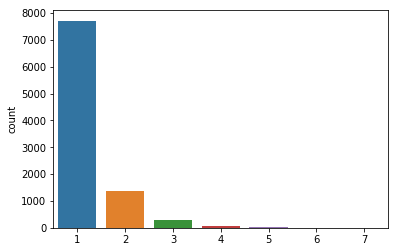

In [379]:
s_usernames = pd.Series(usernames)
#maybe remove usernames of length <5. For instance 'B' is a username.
usernames_length = s_usernames.str.len()
s_usernames = s_usernames[usernames_length>4]
usernames_size = s_usernames.str.split().apply(len)
sns.countplot(s_size);
s_usernames = s_usernames[usernames_size==1]
usernames = list(s_usernames)

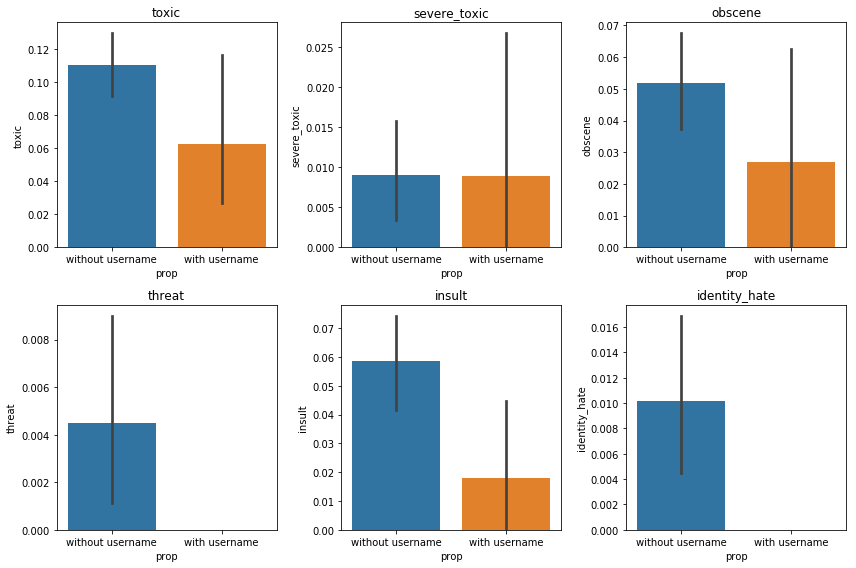

In [369]:
small_train = train_data.iloc[:1000]
s = small_train['comment_text'].str.extract(un_regex)
mask = ~s.isnull()
statistics(mask,data=small_train,prop='username')

In [380]:
usernames_lower = lower_tokenized(usernames)
set_usernames=set(usernames_lower)

In [383]:
def find_username_tokenized(tokenized_comment,set_usernames=set_usernames,TAG_USERNAME=TAG_USERNAME):
    check = False
    for i,token in enumerate(tokenized_comment):  
        if token in set_usernames:
            tokenized_comment[i]=TAG_USERNAME
            check = True
    return tokenized_comment,check
def find_username(comment,set_usernames=set_usernames,TAG_USERNAME=TAG_USERNAME):
    tokenized_comment0 = tokenize(comment)
    tokenized_comment1 = lower_tokenized(tokenized_comment0)
    return find_username_tokenized(tokenized_comment1)

In [473]:
'ui'.upper()

'UI'

In [492]:
def find_username_tokenized2(tokenized_comment,set_usernames=set_usernames,TAG_USERNAME=TAG_USERNAME):
    check = False
    context = ""
    for i,token in enumerate(tokenized_comment):  
        if token in set_usernames:
            c.update([token])
            length = len(tokenized_comment)
            m = max(0,i-5)
            tokenized_comment[i]= tokenized_comment[i].upper()
            M = min(length-1,i+5)
            context = " ".join(tokenized_comment[m:M])
            check = True
            break
    return context, check
def find_username2(comment,set_usernames=set_usernames,TAG_USERNAME=TAG_USERNAME):
    tokenized_comment0 = tokenize(comment)
    tokenized_comment1 = lower_tokenized(tokenized_comment0)
    return find_username_tokenized2(tokenized_comment1)

In [493]:
from collections import Counter
c = Counter()
a = train_text.apply(find_username2)
data_with_username = pd.DataFrame(a.tolist(),columns=['context_username','username'])
# ou a.apply(pd.Series)

In [571]:
#In fact some usernames are very common so it does not work. 
# for instance 'world' is a username
data_with_username.head()
c.most_common(200);

# Playground

In [231]:
def get_random_comment(num=1,train_text=train_text):
    for i in range(num):
        col=np.random.randint(train_size)
        print("Comment: {}.".format(col))
        print(train_text[col])
        print("TARGETS: ",train_targets.iloc[col].values)
        print("\n"+"**"*45)
        print("**"*45 + "\n")

In [232]:
get_random_comment(num=20,train_text=tagged_train_text)

Comment: 45940.
good faith standards.. As this user is being protect by a group of rouge admits.. Members of the wikiepida community have decided to removed this user in good faith until the admins who we can trust,  look into this matter... This user will not be allowed to post and should be considered banned until a high ranking admin can review this users gross misconduct as well as the admins who violated gross misconduct rules to protect thus disgusting user.
TARGETS:  [0 0 0 0 0 0]

******************************************************************************************
******************************************************************************************

Comment: 46043.
"

Welcome

Hello and welcome to Wikipedia!  We appreciate encyclopedic contributions, but some of your recent contributions do not conform to our policies.  For more information on this, see Wikipedia's policies on vandalism and limits on acceptable additions. If you'd like to experiment with the wiki's s

In [71]:
def sent_nonempty(sentence):
    """Check if a sentence is not empty (or nearly empty)"""
    return re.search(r'\w\w',sentence)
def process_sentence(sentence):
    pass
def remove_empty_sentences(sentences):
    """Take a liste of sentences and remove the sentences which are empty."""
    return[sentence for sentence in sentences if sent_nonempty(sentence)]
# list(remove_empty_sentences(example1))

In [72]:
def remove_newlines(sentences):
    return [ sent for sentence in sentences  for sent in sentence.split("\n") if sent_nonempty(sent)  ]
# a = "\n ok \n ok\n".split("\n")
# remove_newlines(a)

In [73]:
train_text1=train_text.apply(nltk.sent_tokenize)

In [74]:
train_text2=train_text1.apply(remove_newlines)

In [75]:
#train_text2 = train_text1.apply(remove_empty_sentences)

In [76]:
# train_text3 = train_text.apply(sent_tok)
# train_text4 = train_text3.apply(remove_empty_sentences)

In [77]:
train_text4=train_text2

In [78]:
train_text4.head()

0    [Explanation, Why the edits made under my user...
1    [D'aww!, He matches this background colour I'm...
2    [Hey man, I'm really not trying to edit war., ...
3    [More, I can't make any real suggestions on im...
4    [You, sir, are my hero., Any chance you rememb...
Name: comment_text, dtype: object

In [80]:
def strip_sentences(sentences):
    sentences[0] = sentences[0].lstrip()
    sentences[-1] = sentences[-1].rstrip()
    return sentences
# strip_sentences(['\n ok ii','ok ','humm \n'])

# Print random comments

In [89]:
line = 0
def print_random_line(num=1,pos='first_and_last',doc=train_text4):
    for i in range(num):
        col = np.random.randint(train_size)
        print("Comment {}".format(col))
        comment = doc[col]
        if pos=='first_and_last':
            print("FIRST LINE: "+ comment[0])
            print("LAST LINE: "+ comment[-1])
        elif pos=='first':
            print("FIRST LINE: "+comment[0])
        if pos=='last':
            print("LAST LINE: "+comment[-1])
        print("TARGETS: ",train_targets.iloc[col].values)
        print("\n"+"="*80+"\n")
        global line
        line = col

In [441]:
print_random_line(num=20)

NameError: name 'print_random_line' is not defined

# SpaCy

In [193]:
nlp0 = spacy.load('en')

## Playground with Spacy

In [547]:
#text= """
# This is a text used for an example for Koen and Florent and for Kaggle. 
# This is a  uitrnl that doesn't exist.
# Feb 7, 2018. 
# """
text = train_text[48769]
doc1 = nlp(text)

In [548]:
text=train_text.sample(1).iloc[0]
doc1 = nlp(text)

In [567]:
# html = displacy.render(doc1, style='dep')
# display(HTML(html))
def print_spacy(text,model=nlp):
    doc = model(text)
    html = displacy.render(doc, style='ent',page=True)
    display(HTML(html))

In [199]:
for token in doc1:
    print(token.text,":   ", token.lemma_, token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

June :    june PROPN NNP npadvmod Xxxx True False
2006 :    2006 NUM CD nummod dddd False False
( :    ( PUNCT -LRB- punct ( False False
UTC :    utc NOUN NN ROOT XXX True False
) :    ) PUNCT -RRB- punct ) False False

 :    
 SPACE   
 False False
I :    -PRON- PRON PRP nsubj X True False
dispute :    dispute VERB VBP ROOT xxxx True False
that :    that ADP IN mark xxxx True True
Equestris :    equestris PROPN NNP nsubjpass Xxxxx True False
was :    be VERB VBD auxpass xxx True True
later :    later ADV RB advmod xxxx True False
refashioned :    refashion VERB VBN ccomp xxxx True False
into :    into ADP IN prep xxxx True True
Gemina :    gemina PROPN NNP pobj Xxxxx True False
. :    . PUNCT . punct . False False
As :    as ADP IN mark Xx True False
I :    -PRON- PRON PRP nsubj X True False
have :    have VERB VBP aux xxxx True True
said :    say VERB VBN advcl xxxx True False
many :    many ADJ JJ amod xxxx True True
times :    time NOUN NNS npadvmod xxxx True False
before :    befo

### Named Entity Recognation (NER) with SpaCy

In [550]:
def print_ner(model,text="",row=None,train_text=train_text):
    if row:
        text=train_text[row]
    else:
        if not text: print("text and row empty")
    doc = model(text)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)  
# text = train_text[48769]
# print_ner(nlp,text)

In [552]:
import en_core_web_sm
nlp1 = en_core_web_sm.load()
# print_ner(nlp2,text)
import en_core_web_md
nlp2 = en_core_web_md.load()
# print_ner(nlp3,text)
import en_core_web_lg
nlp3 = en_core_web_lg.load()
#print_ner(nlp4,text)

In [183]:
# nlp5 = spacy.load('en_vectors_web_lg')
# print_ner(nlp5,text)

### NER with NLTK

In [576]:
def print_ner_nltk(comment):
    a = nltk.pos_tag(nltk.word_tokenize(comment))  
    t=nltk.ne_chunk(a)
    return t

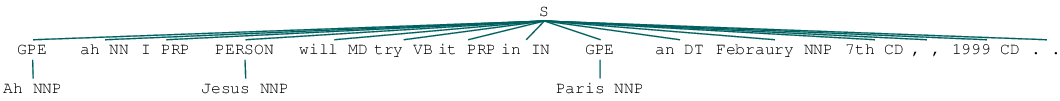

In [581]:
print_ner_nltk('Ah ah I Jesus will try it in Paris an Febraury 7th, 1999.')

In [367]:
t=nltk.ne_chunk(a)

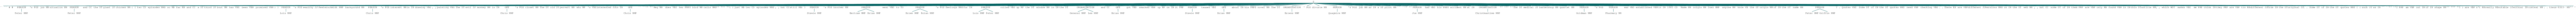

In [368]:
t

In [161]:
print(t)

(S
  ``/``
  #/#
  (PERSON Peter/NNP)
  's/POS
  job/NN
  situation/NN
  (PERSON Peter/NNP)
  and/CC
  the/DT
  giant/JJ
  chicken/NN
  (/(
  two/CD
  episodes/NNS
  so/RB
  far/RB
  and/CC
  a/DT
  third/JJ
  bout/NN
  has/VBZ
  been/VBN
  promised/VBN
  )/)
  (PERSON Lois/NNP)
  's/POS
  wealthy/JJ
  Pewterschmidt/NNP
  background/NN
  (PERSON Chris/NNP)
  's/POS
  interest/NN
  in/IN
  drawing/VBG
  ,/,
  painting/VBG
  The/DT
  evil/JJ
  monkey/NN
  in/IN
  (GPE Chris/NNP)
  's/POS
  closet/NN
  The/DT
  old/JJ
  pervert/NN
  who/WP
  's/VBZ
  interested/JJ
  in/IN
  (GPE Chris/NNP)
  ``/``
  ''/''
  Meg/NN
  does/VBZ
  her/PRP$
  bird/NN
  calls/NNS
  ''/''
  ''/''
  (/(
  just/RB
  two/CD
  episodes/NNS
  ,/,
  but/CC
  still/RB
  )/)
  (PERSON Stewie/NNP)
  's/POS
  brother/NN
  (PERSON Bertram/NNP Brian/NNP)
  went/VBD
  to/TO
  (PERSON Brown/NNP Brian/NNP)
  's/POS
  feelings/NNS
  for/IN
  (PERSON Lois/NNP Peter/NNP)
  rolled/VBD
  up/RP
  the/DT
  window/NN
  in/IN
  the/DT


In [160]:
print(str(t));

(S
  ``/``
  #/#
  (PERSON Peter/NNP)
  's/POS
  job/NN
  situation/NN
  (PERSON Peter/NNP)
  and/CC
  the/DT
  giant/JJ
  chicken/NN
  (/(
  two/CD
  episodes/NNS
  so/RB
  far/RB
  and/CC
  a/DT
  third/JJ
  bout/NN
  has/VBZ
  been/VBN
  promised/VBN
  )/)
  (PERSON Lois/NNP)
  's/POS
  wealthy/JJ
  Pewterschmidt/NNP
  background/NN
  (PERSON Chris/NNP)
  's/POS
  interest/NN
  in/IN
  drawing/VBG
  ,/,
  painting/VBG
  The/DT
  evil/JJ
  monkey/NN
  in/IN
  (GPE Chris/NNP)
  's/POS
  closet/NN
  The/DT
  old/JJ
  pervert/NN
  who/WP
  's/VBZ
  interested/JJ
  in/IN
  (GPE Chris/NNP)
  ``/``
  ''/''
  Meg/NN
  does/VBZ
  her/PRP$
  bird/NN
  calls/NNS
  ''/''
  ''/''
  (/(
  just/RB
  two/CD
  episodes/NNS
  ,/,
  but/CC
  still/RB
  )/)
  (PERSON Stewie/NNP)
  's/POS
  brother/NN
  (PERSON Bertram/NNP Brian/NNP)
  went/VBD
  to/TO
  (PERSON Brown/NNP Brian/NNP)
  's/POS
  feelings/NNS
  for/IN
  (PERSON Lois/NNP Peter/NNP)
  rolled/VBD
  up/RP
  the/DT
  window/NN
  in/IN
  the/DT


### NER with Stanford NLP

With https://github.com/Lynten/stanford-corenlp

In [102]:
from stanfordcorenlp import StanfordCoreNLP

In [104]:
nlp = StanfordCoreNLP(r'/Users/florentmartin/stanford-corenlp-full-2018-01-31/', memory='8g')

KeyboardInterrupt: 

In [ ]:
print(nlp.ner(text))

### With pycorenlp
https://github.com/smilli/py-corenlp
In the terminal, enter the command:

java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000 (I guesse it worked if the command is executed form the stanfordCoreNLP folder, which is (February 2018) /Users/florentmartin/stanford-corenlp-full-2018-01-31

Alternatively, once the classpath environement variable has been set the following work

java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

then the following can work

In [105]:
from pycorenlp import StanfordCoreNLP

In [106]:
nlp = StanfordCoreNLP('http://localhost:9000')

In [108]:
text = "We want to analyse this texte. Today is the first of February 2018. I live in Munich."

In [109]:
# output = nlp.annotate(text, properties={
#   'annotators': 'tokenize,ssplit,pos,depparse,parse,ner',
#   'outputFormat': 'json'
#   })
output = nlp.annotate(text, properties={
  'annotators': 'ssplit,ner,depparse',
  'outputFormat': 'json'
  })

In [123]:
last_sentence = output['sentences'][-1]
last_sentence.keys()

dict_keys(['index', 'basicDependencies', 'enhancedDependencies', 'enhancedPlusPlusDependencies', 'entitymentions', 'tokens'])

In [124]:
output['sentences']

[{'basicDependencies': [{'dep': 'ROOT',
    'dependent': 2,
    'dependentGloss': 'want',
    'governor': 0,
    'governorGloss': 'ROOT'},
   {'dep': 'nsubj',
    'dependent': 1,
    'dependentGloss': 'We',
    'governor': 2,
    'governorGloss': 'want'},
   {'dep': 'mark',
    'dependent': 3,
    'dependentGloss': 'to',
    'governor': 4,
    'governorGloss': 'analyse'},
   {'dep': 'xcomp',
    'dependent': 4,
    'dependentGloss': 'analyse',
    'governor': 2,
    'governorGloss': 'want'},
   {'dep': 'det',
    'dependent': 5,
    'dependentGloss': 'this',
    'governor': 6,
    'governorGloss': 'texte'},
   {'dep': 'dobj',
    'dependent': 6,
    'dependentGloss': 'texte',
    'governor': 4,
    'governorGloss': 'analyse'},
   {'dep': 'punct',
    'dependent': 7,
    'dependentGloss': '.',
    'governor': 2,
    'governorGloss': 'want'}],
  'enhancedDependencies': [{'dep': 'ROOT',
    'dependent': 2,
    'dependentGloss': 'want',
    'governor': 0,
    'governorGloss': 'ROOT'},
   {

In [126]:
last_sentence['enhancedDependencies']

[{'dep': 'ROOT',
  'dependent': 2,
  'dependentGloss': 'live',
  'governor': 0,
  'governorGloss': 'ROOT'},
 {'dep': 'nsubj',
  'dependent': 1,
  'dependentGloss': 'I',
  'governor': 2,
  'governorGloss': 'live'},
 {'dep': 'case',
  'dependent': 3,
  'dependentGloss': 'in',
  'governor': 4,
  'governorGloss': 'Munich'},
 {'dep': 'nmod:in',
  'dependent': 4,
  'dependentGloss': 'Munich',
  'governor': 2,
  'governorGloss': 'live'},
 {'dep': 'punct',
  'dependent': 5,
  'dependentGloss': '.',
  'governor': 2,
  'governorGloss': 'live'}]

### Stanford NER with nltk
https://stackoverflow.com/questions/34037094/setting-nltk-with-stanford-nlp-both-stanfordnertagger-and-stanfordpostagger-fo

One should first run CoreNLP on a server, for instance with the command
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

In [127]:
from nltk.tag.stanford import CoreNLPPOSTagger, CoreNLPNERTagger

In [128]:
tagger1 = CoreNLPPOSTagger(url='http://localhost:9000',encoding='utf8')
tagger2 = CoreNLPNERTagger(url='http://localhost:9000',encoding='utf8')

In [167]:
text = train_text[27915]
print(text)

"# Peter's job situation
 Peter and the giant chicken (two episodes so far and a third bout has been promised)
 Lois's wealthy Pewterschmidt background
 Chris's interest in drawing, painting
 The evil monkey in Chris's closet
 The old pervert who's interested in Chris
 ""Meg does her bird calls"" (just two episodes, but still)
 Stewie's brother Bertram
 Brian went to Brown
 Brian's feelings for Lois
 Peter rolled up the window in the General Lee and Brian got smacked up on it
 Stewie teases Brian about his novel
 The Browns' divorce
 Quagmire's job as a pilot
 ""Joe had his accident at Christmastime""
 The medical barbershop quartet
 Goldman's Pharmacy was established in 1983

 Name origin  

Does anyone know the origin of the name Peter Griffin?

 Qoutes 

Some of the quotes need checking.  
There are different versions on the web, but some of them are only found in this article, which makes me think they are too different from the original.
Some of the quotes (such as ""I am out of s

In [131]:
tagger1.tag(u'Some text with America. This was written on October 8, 2017'.split())

[('Some', 'DT'),
 ('text', 'NN'),
 ('with', 'IN'),
 ('America', 'NNP'),
 ('.', '.'),
 ('This', 'DT'),
 ('was', 'VBD'),
 ('written', 'VBN'),
 ('on', 'IN'),
 ('October', 'NNP'),
 ('8', 'CD'),
 (',', ','),
 ('2017', 'CD')]

In [164]:
#tagger2.tag(u'Some fudi text with America. This was written on October 8, 2017'.split())
tagger2.tag(text.split());

#### Another way with nltk, but not working

In [134]:
import os
from nltk.parse import stanford
os.environ['STANFORD_PARSER'] = r'/Users/florentmartin/stanford-corenlp-full-2018-01-31/'
os.environ['STANFORD_MODELS'] = r'/Users/florentmartin/stanford-corenlp-full-2018-01-31/'

In [ ]:
parser = stanford.StanfordParser(model_path="/location/of/the/englishPCFG.ser.gz")
sentences = parser.raw_parse_sents(("Hello, My name is Melroy.", "What is your name?"))
print sentences

### With CountVectorizer

In [70]:
countvect = CountVectorizer()
countvect.fit(train_text)
list_of_features1=countvect.get_feature_names()
print("Numberof features with raw Countvectorizer: {}".format(len(list_of_features1)))

Numberof features with raw Countvectorizer: 189775


In [71]:
countvect2 = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
countvect2.fit(train_text)
list_of_features2=countvect2.get_feature_names()
print("Numberof features with option Countvectorizer: {}".format(len(list_of_features2)))

Numberof features with option Countvectorizer: 74684


In [76]:
random.choices(list_of_features2,k=30)

['digger',
 'fluoroquinolone',
 'dabbling',
 'i8',
 'witout',
 'motivations',
 'swiftly',
 'provisioning',
 'rectum',
 'andrea',
 'felon',
 'noteability',
 'jubilee',
 'disapproval',
 'kober',
 'buchanan',
 'curtail',
 'extensible',
 'mohammedan',
 'beatle',
 'populum',
 'afaict',
 'styrofoam',
 'xenu',
 'carpenters',
 'neccesary',
 'lesion',
 'naturopathy',
 '795',
 'shaken']

# Playground with tokens

In [45]:
set_of_tokens1={token.lower() for token in set_of_tokens}
list_of_set_of_tokens1 = list(set_of_tokens1)

In [46]:
len(list_of_set_of_tokens1)

251814

In [47]:
random.choice(list_of_set_of_tokens1)

'psychokirby'

In [48]:
wn

<WordNetCorpusReader in '/Users/florentmartin/nltk_data/corpora/wordnet'>

In [49]:
wn.synsets('misssunderstanding')

[]

In [51]:
re.findall(r'(\w)\1{2,}','aeaa')

[]

In [52]:
re.sub(r'(\w)\1{2,}',r'\1\1',"aaaaaaaabcddeeeeeeefggggghhh ")

'aabcddeefgghh '

In [53]:
def replace_word(word):
    if wn.synsets(word): return word
    
    num_consecutive_letters = len(re.findall(r'(\w)\1{2,}',word))
    
    if num_consecutive_letters==1:
        word1 = re.sub(r'(\w)\1{2,}',r'\1\1',word)
        if wn.synsets(word1): return word1 
        word2 = re.sub(r'(\w)\1',r'\1',word1)
        if wn.synsets(word2): return word2
    
    return word

In [54]:
replace_word('illlluzsion')

'illlluzsion'

In [55]:
countvect = CountVectorizer(ngram_range=(1,2))
countvect.fit(train_text)

SyntaxError: invalid syntax (<ipython-input-55-ec5af292e4f9>, line 3)

In [ ]:
countvect = CountVectorizer(ngram_range=(1,2))
countvect.fit(train_text)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
porter_stemmer = nltk.stem.PorterStemmer()
lancaster_stemmer = nltk.stem.LancasterStemmer()
snowball_stemmer=nltk.stem.SnowballStemmer('english')
# porter_stemmer.stem('loving')

In [ ]:
porter_stemmer.stem('fuckrrrres')

In [ ]:
lemmatize_sentence('this is a sentence')

In [ ]:
train_targets.mean()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_text, train_targets, test_size=0.1, random_state=42)

In [56]:
count_vect = CountVectorizer(ngram_range=(1,2))

In [57]:
X_train_counts = count_vect.fit_transform(X_train)

NameError: name 'X_train' is not defined

In [58]:
X_val_counts = count_vect.transform(X_val)

NameError: name 'X_val' is not defined

In [59]:
mnnb = MultinomialNB()

In [60]:
toxic = y_train['toxic']
identity_hate = y_train['identity_hate']

NameError: name 'y_train' is not defined

In [61]:
mnnb.fit(X_train_counts, toxic)

NameError: name 'X_train_counts' is not defined

In [62]:
mnnb.score(X_train_counts, toxic)

NameError: name 'X_train_counts' is not defined

In [63]:
mnnb.predict_proba(X_val_counts).shape

NameError: name 'X_val_counts' is not defined

In [64]:
pred = mnnb.predict_proba(X_val_counts)[:,1]

NameError: name 'X_val_counts' is not defined

In [18]:
pred.shape

(15958,)

In [19]:
(pred == y_val['toxic']).mean()

0.028261686928186491

In [20]:
metrics.confusion_matrix(y_val['toxic'], pred)

ValueError: Can't handle mix of binary and continuous

In [21]:
metrics.roc_auc_score(y_val['toxic'], pred)

0.83354339109104969

In [22]:
toxic.shape

(143613,)

In [23]:
pred[0]

7.0232827978451271e-28

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_val['toxic'], pred, pos_label=1)

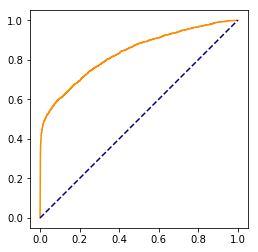

In [25]:
plt.figure()
plt.axes().set_aspect('equal')
plt.plot(fpr, tpr, color="darkorange")
plt.plot([0,1], [0,1], color="navy", linestyle="--")


In [26]:
mnnb.fit(X_train_counts, y_train['identity_hate'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
pred_idhate = mnnb.predict_proba(X_val_counts)[:,1]

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_val['identity_hate'], pred_idhate, pos_label=1)

In [29]:
fpr_c, tpr_c, thresholds_c = metrics.roc_curve(y_val['identity_hate'], np.zeros_like(y_val['identity_hate']), pos_label=1)

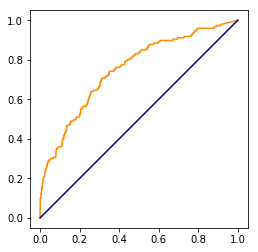

In [30]:
plt.figure()
plt.axes().set_aspect('equal')
plt.plot(fpr, tpr, color="darkorange")
plt.plot(fpr_c, tpr_c, color="navy")


# RNN
Possible references:
https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras